### Дано:

* Тренировочные данные состоят из 323 наблюдений, в каждом из которых есть 40 сигналов датчиков снятые 100 раз с равными промежутками времени.

* Тренировочные данные получены следующим образом: пилоту показываю жест - пилот повторяет жест (всё это время датчики регистрирую какие-то параметры) логично, что между командой на выполнение жеста и самим жестом проходит како-то время ($\Delta t$) 

### Задача: 
* Определить какой из 8ми жестов был показан в тестовых наблюдениях

### Проблема: 
* Существует изменяющаяся от наблюдения к наблюдению задержка между "жестом" и его регистрацией датчиками

### Метрика:
* Mean F-score

### Методика:

1. Определим ключевые датчики
2. Определим задержку 
3. Подготовим данные к загрузке в модель
4. Обучим модель
5. Подготовим submission

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt

### 0. Загрузим данные

In [2]:
data_train = np.load('X_train.npy')
data_test = np.load('X_test.npy')
data_y_train = pd.read_csv('y_train.csv')

print('Форма данных на входе:')
print(data_train.shape, data_y_train.shape, data_test.shape)

# Поменяем местами время и датчики 
data_train = data_train.swapaxes(1, 2)
data_test = data_test.swapaxes(1, 2)

# Преобразуем массивы в pd.DataFrame
lst_1 = []
for i in np.arange(data_train.shape[0]):
    lst_1.extend(data_train[i])
    
lst_2 = []
for i in np.arange(data_test.shape[0]):
    lst_2.extend(data_test[i])
    
data_train = pd.DataFrame(np.array(lst_1))
data_test = pd.DataFrame(np.array(lst_2))

# Добавим в тестовый сет данные о классах
data_train = data_train.join(data_y_train, how='left')
data_train['sample'] = data_train['sample-timestep'].apply(lambda x: x.split('-', 1)[0]).astype(int)
data_train['time'] = data_train['sample-timestep'].apply(lambda x: x.split('-', 1)[1]).astype(int)

print('Форма данных после предобработки:')
print(data_train.shape, data_test.shape)

Форма данных на входе:
(323, 40, 100) (32300, 2) (54, 40, 100)
Форма данных после предобработки:
(32300, 44) (5400, 40)


### 1. Определим ключевые датчики

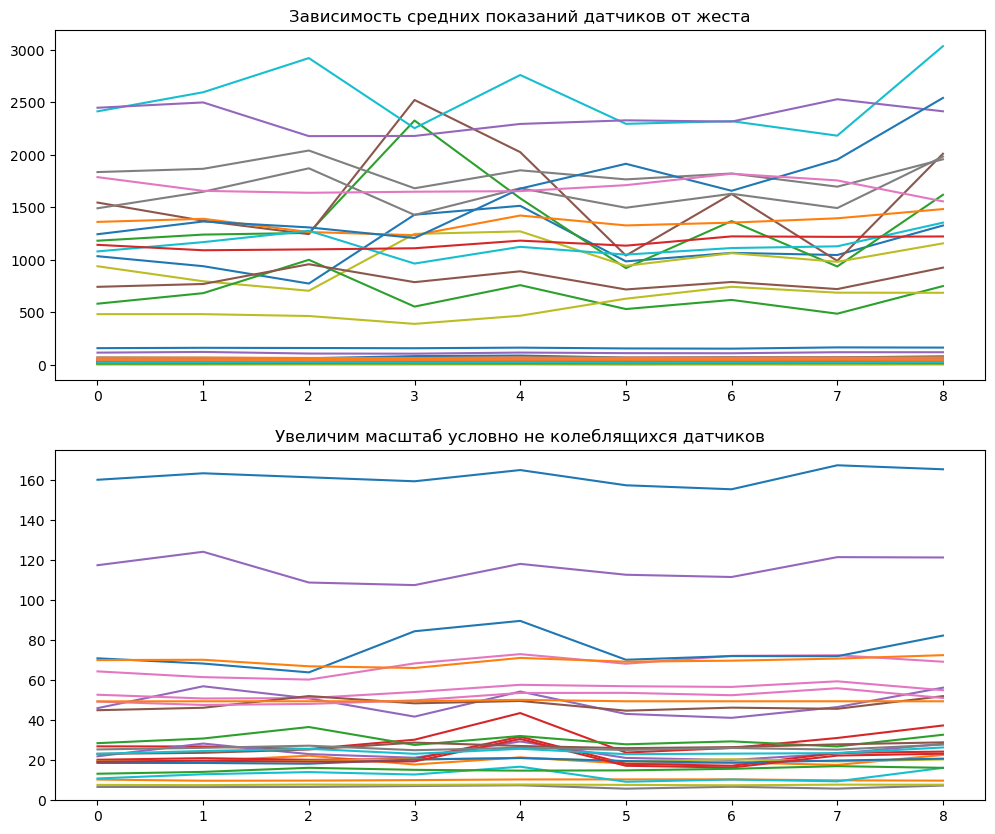

In [5]:
fig, axx = plt.subplots(2, 1, figsize=(12, 10))
axx[0].plot(data_train.groupby('class').mean())
axx[0].set_title('Зависимость средних показаний датчиков от жеста')

axx[1].plot(data_train.groupby('class').mean())
axx[1].set_title('Увеличим масштаб условно не колеблящихся датчиков')
axx[1].set_ylim(0,175);

In [6]:
# Определим "неинформативные" датчики
col_to_drop = []
for i in np.arange(40):
    if data_train[i].mean() < 175:
        col_to_drop.append(i)
        
# И дропнем их из данных
data_train = data_train.drop(col_to_drop, axis=1)
data_test = data_test.drop(col_to_drop, axis=1)

### 2. Определим задержку по ответам

* Определим изменения в позанаих датчиков для каждого наблюдения

* Сгладим полученные результаты скользящим средним

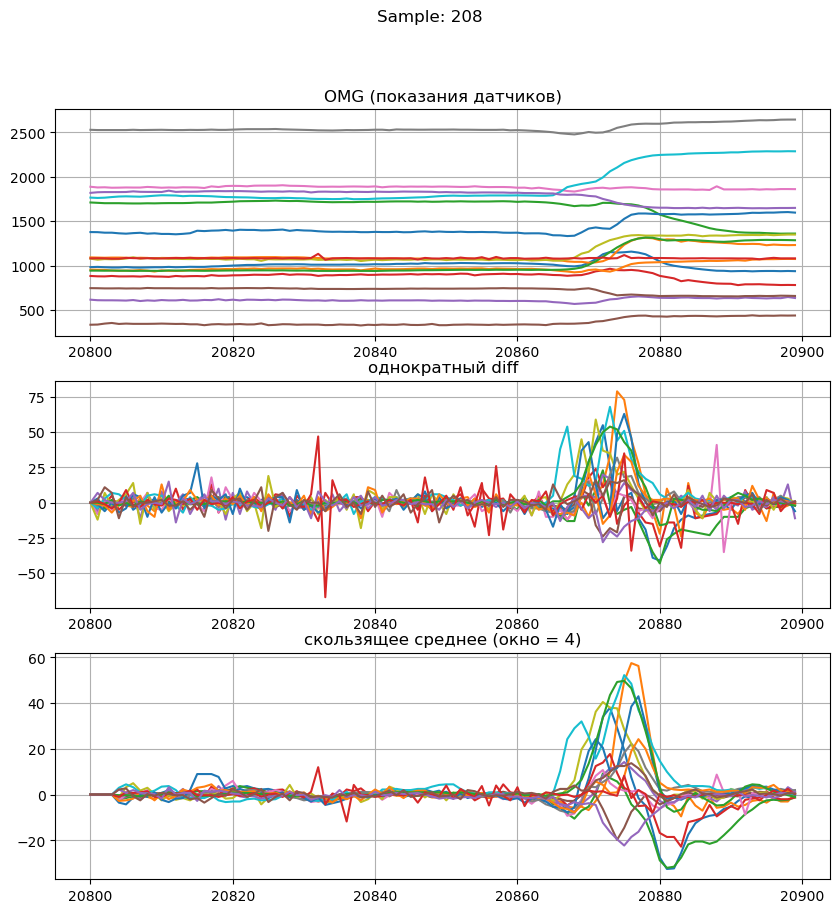

In [306]:
i = np.random.randint(323)
fig, axx = plt.subplots(nrows=3, figsize=(10, 10))
plt.suptitle(f'Sample: {i}')


axx[0].set_title('OMG (показания датчиков)')
axx[0].grid()
axx[0].plot(data_train[[0,2,5,8,12,15,17,19,21,24,27,29,30,33,36,38]][data_train['sample'] == i])

axx[1].set_title('однократный diff')
axx[1].grid()
axx[1].plot(data_train[[0,2,5,8,12,15,17,19,21,24,27,29,30,33,36,38]][data_train['sample'] == i].diff().fillna(0));

axx[2].set_title('скользящее среднее (окно = 4)')
axx[2].grid()
axx[2].plot(data_train[[0,2,5,8,12,15,17,19,21,24,27,29,30,33,36,38]][data_train['sample'] == i].diff().rolling(4).mean().fillna(0));

* Просуммируем полученные средние изменения по каждой строке

* Определим время "начала жеста"

In [319]:
# Добавим предикт sum
data_train['sum'] = data_train[[0,2,5,8,12,15,17,19,21,24,27,29,30,33,36,38]].diff().rolling(4).mean().fillna(0).sum(axis=1).abs()

# Определим функцию сдвигающую class (жест) на время задержки
def shift_fixer(data_train, n=79):
    """_убиратель задержек_

    Args:
        n (int, optional): _граница начала жеста_. Менять в сторону уменьшения.
    """
    res = []
    for i in np.arange(data_train['sample'].max()+1):
        data = data_train[['sum', 'class', 'sample']][data_train['sample'] == i]
        curr_class = data['class'].iloc[0]
        for j in np.arange(100):
            if abs(data['sum'].iloc[j]) < n:
                res.append(curr_class)
            else:
                curr_class = data['class'].iloc[j]
                res.append(curr_class)
    return res
# Добавим исправленный class в данные
data_train['fixed_class'] = shift_fixer(data_train)

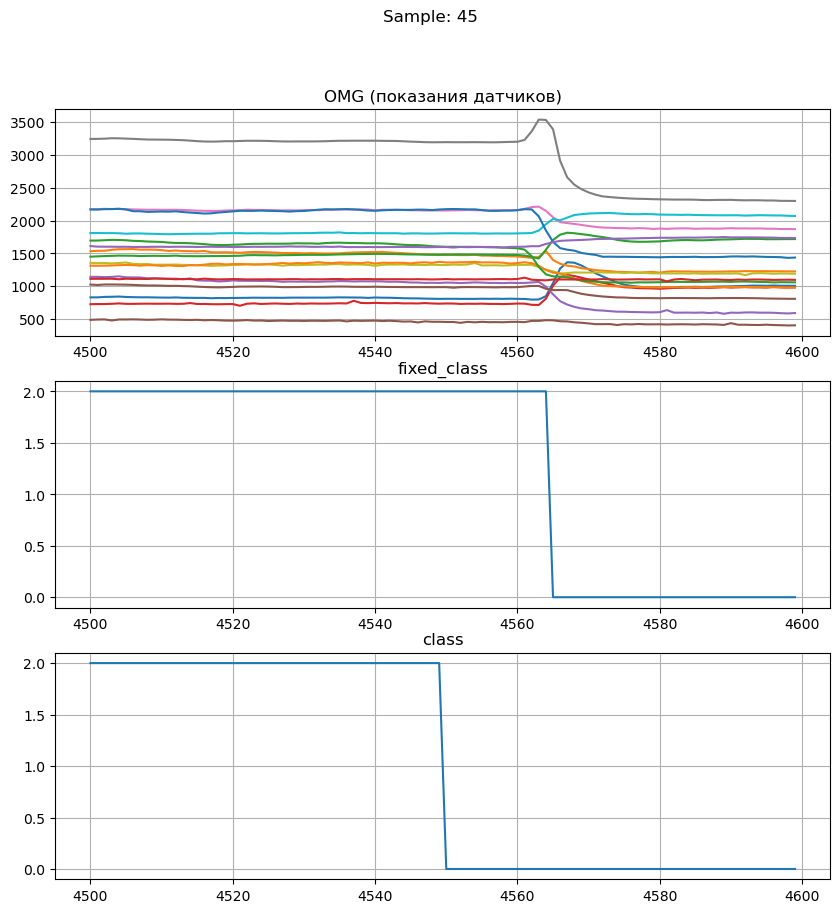

In [320]:
i = np.random.randint(323)
i = 45

fig, axx = plt.subplots(nrows=3, figsize=(10, 10))
plt.suptitle(f'Sample: {i}')

axx[0].set_title('OMG (показания датчиков)')
axx[0].grid()
axx[0].plot(data_train[[0,2,5,8,12,15,17,19,21,24,27,29,30,33,36,38]][data_train['sample'] == i])

axx[1].set_title('fixed_class')
axx[1].grid()
axx[1].plot(data_train[['fixed_class']][data_train['sample'] == i]);

axx[2].set_title('class')
axx[2].grid()
axx[2].plot(data_train[['class']][data_train['sample'] == i]);

In [321]:
# Убедимся что по всем наблюдениям произошло смещение класса
unshifted = []
for i in np.arange(data_train['sample'].max()+1):
    dif = data_train['class'][data_train['sample'] == i].diff().sum() - data_train['fixed_class'][data_train['sample'] == i].diff().sum()
    if abs(dif) != 0: # значение получено экспериментально
        unshifted.append([i,dif])

(f'Необработанные наблюдения: {len(unshifted) != 0}')

'Необработанные наблюдения: False'

### 3. Подготовим данные к моделированию

In [322]:
X = data_train.drop(['sample-timestep','class','sample','time','sum', 'fixed_class'], axis=1)
X_sub = data_test
y = data_train['fixed_class']

# Выполним разбивку
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((25840, 16), (25840,), (6460, 16), (6460,))

### Скалирование и нормализация данных только ухудшают метрику

In [323]:
# Подготовом сеты данных
train_dataset = lgb.Dataset(X_train, y_train)
test_dataset = lgb.Dataset(X_valid, y_valid)

# потренируем модель
booster = lgb.train({"objective": "multiclass", "num_class":9, "verbosity": -1},
                    train_set=train_dataset, valid_sets=(test_dataset,),
                    num_boost_round=200)

# Сделаем предсказания
train_preds = booster.predict(X_train)
valid_preds = booster.predict(X_valid)
set_preds = booster.predict(X)

train_preds = np.argmax(train_preds, axis=1)
valid_preds = np.argmax(valid_preds, axis=1)
set_preds = np.argmax(set_preds, axis=1)

# Выведем метрику
print("\nTrain F1: %.6f"%f1_score(y_train, train_preds, average="macro"))
print("Valid F1: %.6f"%f1_score(y_valid, valid_preds, average="macro"))
print("Whole set F1: %.6f"%f1_score(y, set_preds, average="macro"))

[1]	valid_0's multi_logloss: 0.883446
[2]	valid_0's multi_logloss: 0.707146
[3]	valid_0's multi_logloss: 0.58338
[4]	valid_0's multi_logloss: 0.490033
[5]	valid_0's multi_logloss: 0.41671
[6]	valid_0's multi_logloss: 0.357833
[7]	valid_0's multi_logloss: 0.309269
[8]	valid_0's multi_logloss: 0.270133
[9]	valid_0's multi_logloss: 0.237595
[10]	valid_0's multi_logloss: 0.210412
[11]	valid_0's multi_logloss: 0.187668
[12]	valid_0's multi_logloss: 0.168501
[13]	valid_0's multi_logloss: 0.151641
[14]	valid_0's multi_logloss: 0.137657
[15]	valid_0's multi_logloss: 0.125699
[16]	valid_0's multi_logloss: 0.116
[17]	valid_0's multi_logloss: 0.107457
[18]	valid_0's multi_logloss: 0.0996137
[19]	valid_0's multi_logloss: 0.0930068
[20]	valid_0's multi_logloss: 0.0870988
[21]	valid_0's multi_logloss: 0.0818813
[22]	valid_0's multi_logloss: 0.0773967
[23]	valid_0's multi_logloss: 0.0731656
[24]	valid_0's multi_logloss: 0.0699674
[25]	valid_0's multi_logloss: 0.0672159
[26]	valid_0's multi_logloss: 0

In [335]:
y_sub.shape

(5400,)

In [337]:
y_sub[1:].shape

(5399,)

In [338]:
# Выполним предсказания для тестовых данных
y_sub = booster.predict(X_sub)
y_sub = np.argmax(y_sub, axis=1)

# Добавим сглаживатель предсказаний
from statistics import mode

def smooth_row(row, mode_value=7):
    smoothing_row = []
    for k in range(len(row)):
        smoothing_row.append(mode(row[k:(k + mode_value)]))
    len(smoothing_row)
    return smoothing_row

#
y_sub = y_sub[1:]
y_sub = np.append(y_sub, [0])



   
# Запишем предсказания в требуемый Kaggle вид
data_y_test = pd.read_csv('sample_submission.csv')
data_y_test['class'] = y_sub
data_y_test['class'] = smooth_row(data_y_test['class'])
data_y_test.set_index('sample-timestep', inplace=True)
data_y_test.to_csv('sample_submission.csv')

### Private Score: 0,89

### Public Score: 0,908

In [325]:
set_preds = booster.predict(X)
set_preds = np.argmax(set_preds, axis=1)

set_preds.shape

(32300,)

In [326]:
set_preds = np.append([0,0,0], set_preds)

set_preds = set_preds[:-3]

In [327]:
set_preds.shape

(32300,)

In [329]:
plot_data

,0,2,5,8,12,15,17,19,21,24,...,33,36,38,sample-timestep,class,sample,time,sum,fixed_class,pred_class
0,1123.0,1450.0,1743.0,1068.0,652.0,783.0,1809.0,2142.0,1416.0,2669.0,...,1169.0,1677.0,718.0,0-0,0,0,0,0.00,0,0
1,1125.0,1441.0,1738.0,1064.0,647.0,788.0,1809.0,2146.0,1417.0,2671.0,...,1170.0,1673.0,730.0,0-1,0,0,1,0.00,0,0
2,1121.0,1444.0,1732.0,1065.0,659.0,792.0,1811.0,2146.0,1415.0,2669.0,...,1169.0,1670.0,727.0,0-2,0,0,2,0.00,0,0
3,1120.0,1440.0,1730.0,1066.0,651.0,793.0,1812.0,2145.0,1427.0,2668.0,...,1165.0,1667.0,726.0,0-3,0,0,3,0.00,0,0
4,1115.0,1437.0,1724.0,1062.0,657.0,792.0,1809.0,2146.0,1415.0,2668.0,...,1165.0,1667.0,724.0,0-4,0,0,4,9.50,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32295,1679.0,1826.0,2250.0,1369.0,842.0,845.0,1931.0,2999.0,1373.0,1943.0,...,1186.0,1689.0,388.0,322-95,4,322,95,41.50,4,4
32296,1673.0,1827.0,2251.0,1371.0,828.0,848.0,1922.0,2991.0,1375.0,1953.0,...,1204.0,1690.0,388.0,322-96,4,322,96,23.00,4,4
32297,1669.0,1832.0,2251.0,1369.0,828.0,853.0,1918.0,2988.0,1379.0,1958.0,...,1203.0,1690.0,390.0,322-97,4,322,97,5.00,4,4
32298,1670.0,1831.0,2249.0,1368.0,832.0,853.0,1923.0,2977.0,1374.0,1960.0,...,1207.0,1691.0,391.0,322-98,4,322,98,23.00,4,4


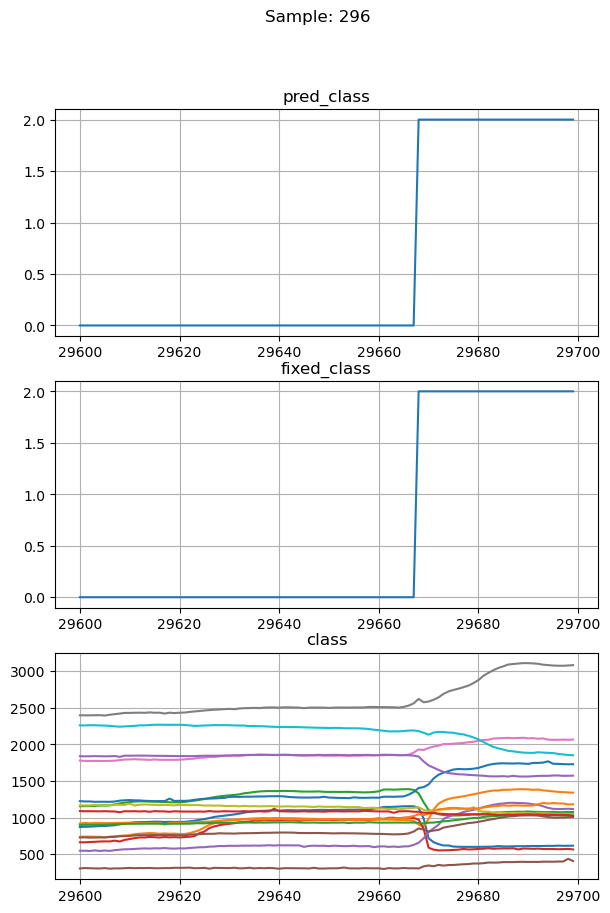

In [332]:
plot_data = data_train.copy()
plot_data['pred_class'] = set_preds
plot_data['pred_class'] = smooth_row(plot_data['pred_class'])

i = np.random.randint(323)
i = 296

fig, axx = plt.subplots(nrows=3, figsize=(7, 10))
plt.suptitle(f'Sample: {i}')

axx[0].set_title('pred_class')
axx[0].grid()
axx[0].plot(plot_data['pred_class'][plot_data['sample'] == i])

axx[1].set_title('fixed_class')
axx[1].grid()
axx[1].plot(plot_data['fixed_class'][plot_data['sample'] == i])

axx[2].set_title('class')
axx[2].grid()
axx[2].plot(data_train[[0,2,5,8,12,15,17,19,21,24,27,29,30,33,36,38]][data_train['sample'] == i]);